In [2]:
from quasinet.qnet import load_qnet
from quasinet.qnet import qdistance
from quasinet.qsampling import qsample
from quasinet.qnet import membership_degree
import pandas as pd
import numpy as np
from tqdm import tqdm
from jupyterthemes import jtplot
jtplot.style()



In [141]:
def dissonance(pos,seq,model):
    if seq[pos]=='':
        return np.nan
    D=model.predict_distributions(seq) 
    return 1-D[pos].get(str(seq[pos]),0)

def dissonance_distr(seq,model):
    return np.array([dissonance(pos,seq,model) for pos in range(len(seq))])

def dissonance_distr_median(seq,model):
    a=dissonance_distr(seq,model)
    return np.median(a[~np.isnan(a)])


# Function to read the JSON file and extract the top-level keys as subject ID and the associated dictionary as responses
def extract_ptsd_items(jsondata):
        data=jsondata
        subjects = []
        for entry in data:
            for subject_id, responses in entry.items():
                subjects.append({"subject_id": subject_id,
                                 "responses": responses})
        return subjects

def reveal(jsondata,model):
    list_response_dict = extract_ptsd_items(jsondata)
    for i in list_response_dict:
        subjectid=i['subject_id']
        resp = i['responses']
        s=pd.concat([pd.DataFrame(columns=model.feature_names),
                   pd.DataFrame(resp,index=['response'])])\
                        .fillna('').values[0].astype(str)
        i['veritas']=dissonance_distr_median(s,model)
    return list_response_dict

import random
def funcw(s,model_pos,model_neg,
          dropone=False,
          perturb=False,
          perturbsteps=100):
    if dropone:
        s[random.randint(0, len(s) - 1)] = str(random.randint(1,5))
    if perturb:
        s=qsample(s,model_neg,steps=perturbsteps)
    return membership_degree(s,model_neg)/membership_degree(s,model_pos)

def classscore(jsondata,model,modelneg):
    list_response_dict = extract_ptsd_items(jsondata)
    for i in tqdm(list_response_dict):
        subjectid=i['subject_id']
        resp = i['responses']
        s=pd.concat([pd.DataFrame(columns=model.feature_names),
                   pd.DataFrame(resp,index=['response'])])\
                        .fillna('').values[0].astype(str)
        i['funcw']=funcw(s,model,modelneg)
    return list_response_dict

modelpath='ptsd_pos.pkl.gz'
model=load_qnet(modelpath)

modelnegpath='ptsd_neg.pkl.gz'
modelneg=load_qnet(modelnegpath)


In [87]:
import json
filepath='/home/ishanu/Dropbox/paraknowledge/paraknowledgecorp/saas/cloud_functions/test_deployments/ptsd1.json'
with open(filepath, 'r') as file:
    data = json.load(file)
R=reveal(data,model)

In [101]:
featurenames=model.feature_names
INDEX=model.shap_index
NULLSTR=np.array(['']*len(model.feature_names))
adict=[]
for i in tqdm(range(10000)):
    sq=qsample(NULLSTR,model,steps=1000)
    ff=pd.DataFrame(sq.reshape(1, -1),
                columns=featurenames)[INDEX[:20]]
    adict=np.append(adict,{'xx'+str(i):ff.iloc[0].to_dict()})

100%|█████████████████████████████████████| 10000/10000 [30:40<00:00,  5.43it/s]


In [102]:
R=reveal(adict,model)

<AxesSubplot:ylabel='Density'>

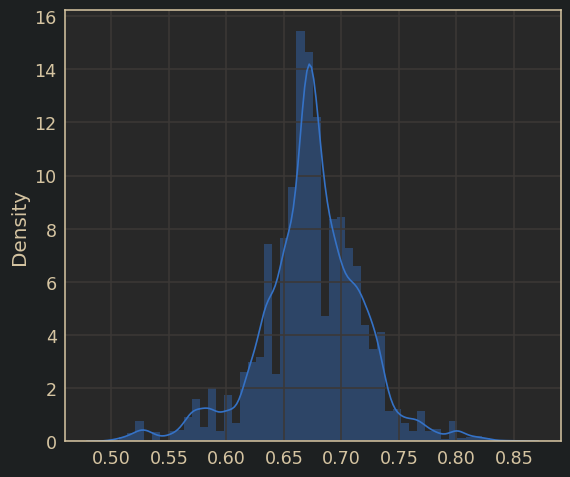

In [103]:
import seaborn as sns
sns.distplot(np.array([i['veritas'] for i in R]))

In [118]:
with open("/home/ishanu/ZED/Research/truthnet/notebooks/deployment-assets/possample_veritas.json", "w") as outfile: 
    json.dump(R, outfile)

In [104]:
vval=np.array([i['veritas'] for i in R])

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [smoothline] >Smoothing by interpolation..
[distfit] >INFO> [t] [0.38 sec] [RSS: 18.2102] [loc=0.675 scale=0.033]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: T(loc:0.674875, scale:0.032612)


(<Figure size 2000x1500 with 1 Axes>,
 <AxesSubplot:title={'center':'\nt(df=3.94435, loc=0.674875, scale=0.0326123)'}, xlabel='Values', ylabel='Frequency'>)

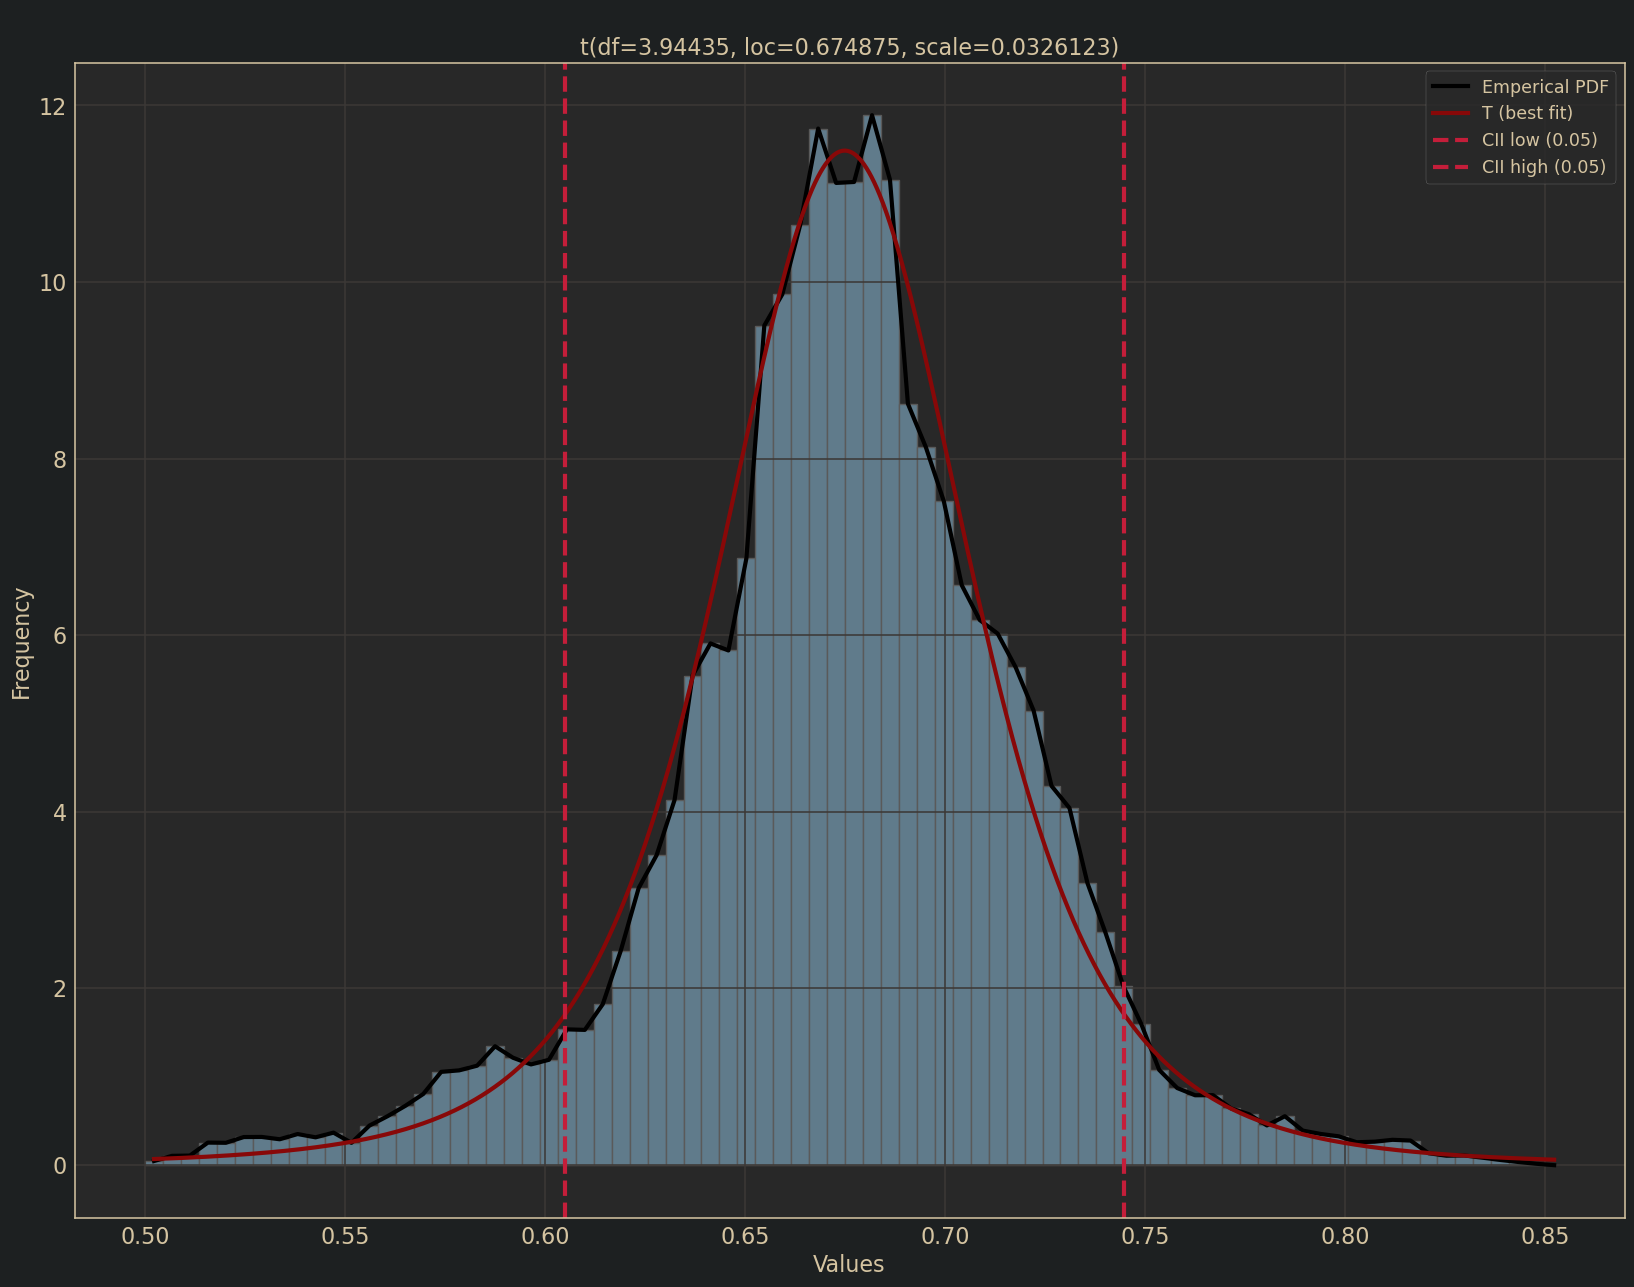

In [113]:
from  distfit import distfit
dfit = distfit(smooth=8,distr='t')
dfit.fit_transform(vval)
dfit.plot()

0.6663798292391938


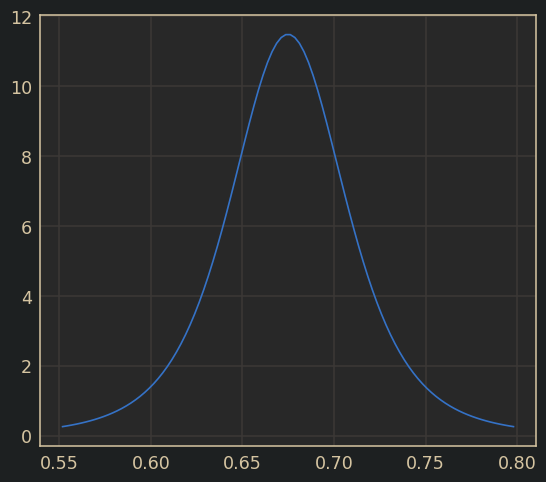

In [129]:
import pylab as plt
params=dfit.model['params']
from scipy.stats import t
t_distribution = t(df=params[0], loc=params[1], scale=params[2])
x = np.linspace(t_distribution.ppf(0.01), t_distribution.ppf(0.99), 100)
pdf = t_distribution.pdf(x)
plt.plot(x,pdf)
print(t_distribution.cdf(.69))

In [169]:
# save veritas model
veritas_ptsd={}
veritas_ptsd['version']='0.0.1'
veritas_ptsd['model']=model
veritas_ptsd['model_neg']=modelneg

veritas_ptsd['t_distribution']=t_distribution
import dill as pickle  # Dill functions similarly to pickle
import gzip
with gzip.open('veritas_ptsd.pkl.gz', 'wb') as f:
    pickle.dump(veritas_ptsd, f)

In [142]:
Score=classscore(adict,model,modelneg)

100%|█████████████████████████████████████| 10000/10000 [11:25<00:00, 14.59it/s]


<AxesSubplot:ylabel='Density'>

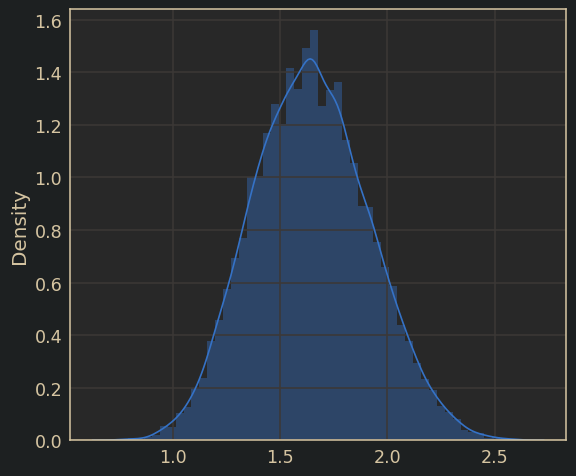

In [146]:
import seaborn as sns
scoreval=np.array([i['funcw'] for i in Score])
sns.distplot(scoreval)

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [smoothline] >Smoothing by interpolation..
[distfit] >INFO> [t] [0.73 sec] [RSS: 0.0742611] [loc=1.643 scale=0.270]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Create pdf plot for the parametric method.
[distfit] >INFO> Estimated distribution: T(loc:1.643402, scale:0.270474)


0.10210852445244956


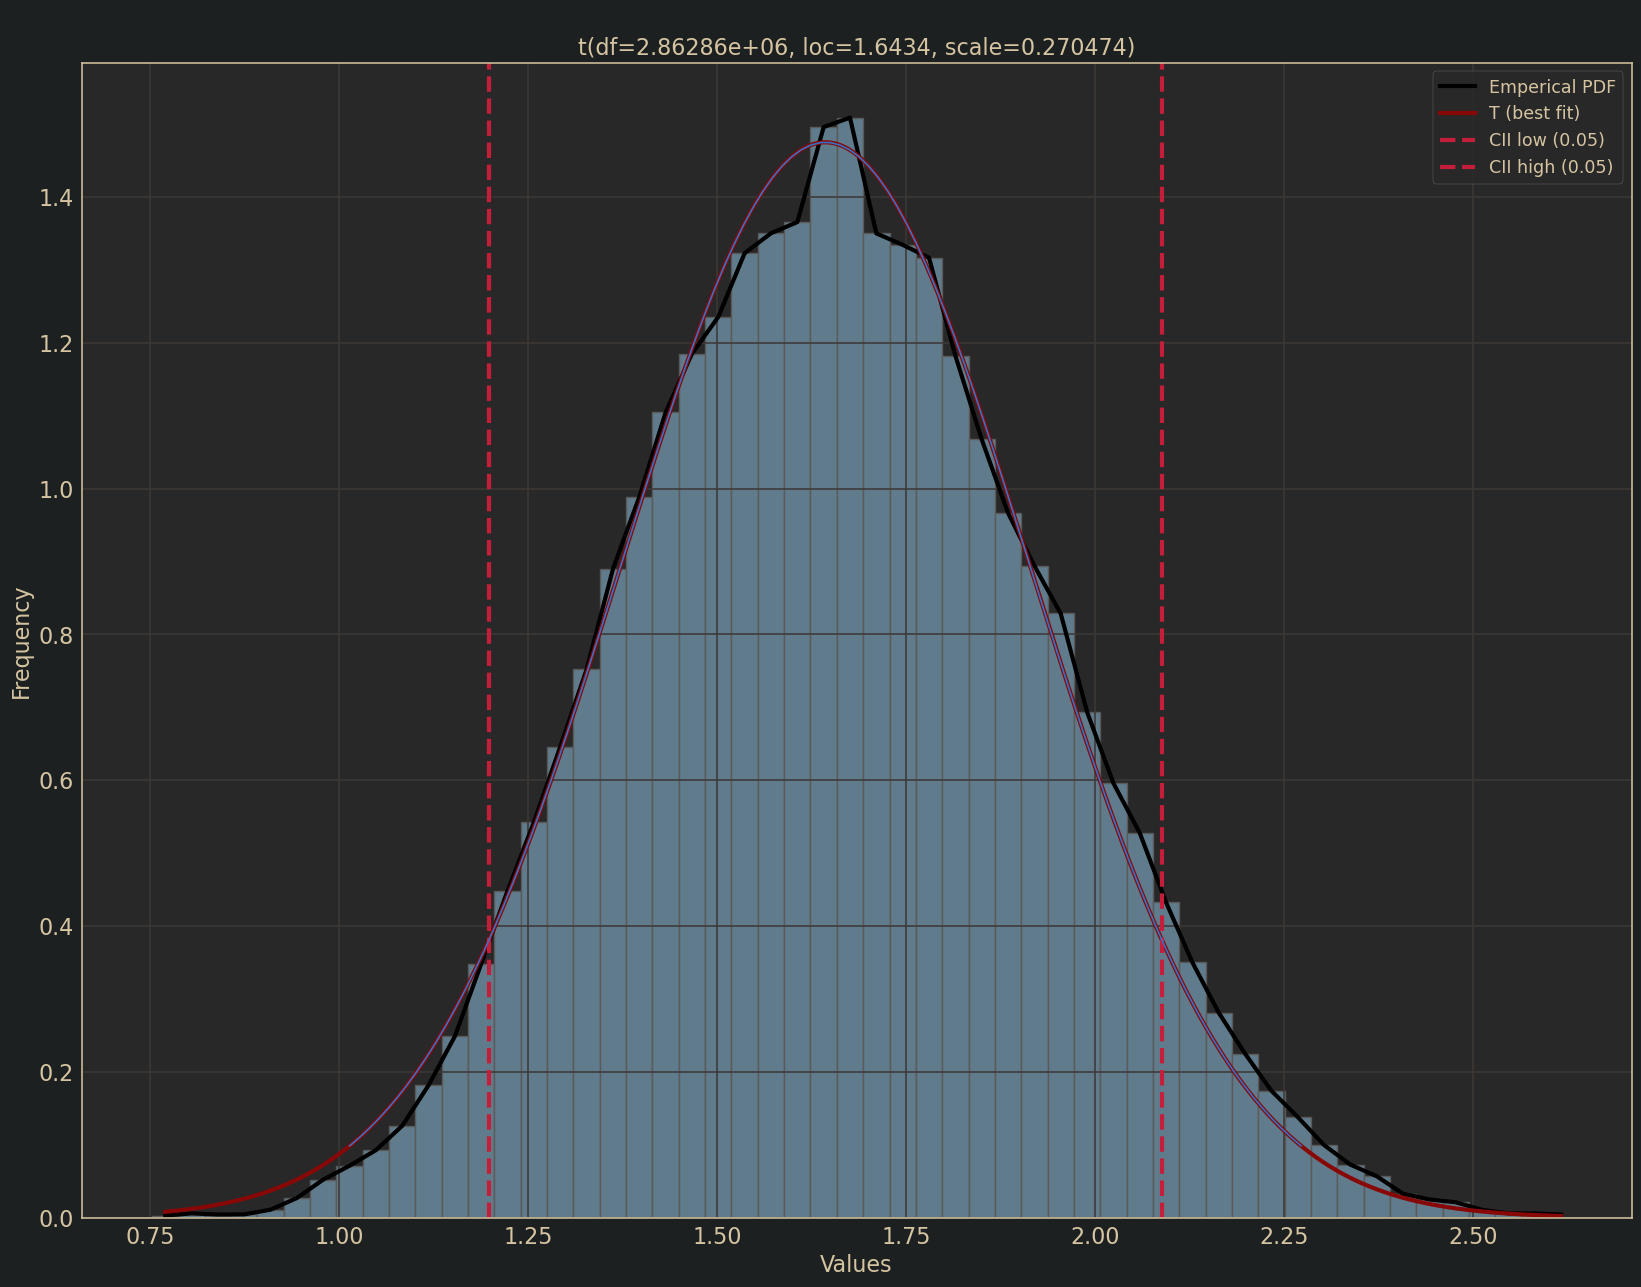

In [167]:
dfit1 = distfit(smooth=2,distr='t')
dfit1.fit_transform(scoreval)
dfit1.plot()
params1=dfit1.model['params']
t_distribution1 = t(df=params1[0], loc=params1[1], scale=params1[2])
x = np.linspace(t_distribution1.ppf(0.01), t_distribution1.ppf(0.99), 100)
pdf1 = t_distribution1.pdf(x)
plt.plot(x,pdf1)
print(t_distribution1.cdf(1.3))

In [99]:
dist={'3':0.3,'4':.2,'5':.5}
#dist={'1':.6,'2':.25,'3':.1,'4':.05,'5':0}
POSSTR=sample_from_pmf(dist,211)
print(membership_degree(POSSTR,model_pos),dissonance_distr_median(POSSTR,model_pos),funcw(POSSTR))
calcVeritas(POSSTR)
# mem > -250, funcw > 1, but diss > .75 ===> malingering

(True, False)

In [119]:
dist={'1':.3,'2':.1,'3':0.2,'4':.3,'5':.1}
#dist={'1':.6,'2':.25,'3':.1,'4':.05,'5':0}
POSSTR=sample_from_pmf(dist,211)
print(funcm(POSSTR),dissonance_distr_median(POSSTR,model_pos),funcw(POSSTR,model_pos,model_neg))
calcVeritas(POSSTR)

# mem > -250, funcw > 1, but diss > .75 ===> malingering

1.4969629242516442 0.834319526627219 1.1427220748856868


(True, False)

In [121]:
sq=qsample(NULLSTR,model_pos,steps=1000)
print(sq,funcm(sq),dissonance_distr_median(sq,model_pos),funcw(sq,model_pos,model_neg))
calcVeritas(sq)

# note for a legitimate rerposnse, funcw > 1, diss < 0.7, mem > -250

['5' '3' '2' '4' '2' '2' '3' '5' '2' '2' '1' '4' '5' '4' '4' '3' '4' '3'
 '4' '4' '1' '1' '3' '3' '4' '3' '3' '4' '3' '5' '2' '3' '5' '4' '3' '3'
 '3' '3' '3' '4' '4' '4' '3' '4' '2' '1' '3' '3' '4' '4' '2' '3' '3' '1'
 '3' '1' '5' '1' '3' '3' '4' '1' '1' '1' '4' '3' '4' '4' '2' '5' '' '2'
 '2' '2' '2' '4' '4' '4' '2' '3' '3' '3' '2' '' '4' '1' '3' '3' '5' '4'
 '4' '4' '3' '3' '3' '4' '5' '2' '4' '5' '3' '3' '1' '3' '2' '4' '4' '4'
 '4' '5' '4' '2' '2' '2' '1' '1' '4' '1' '4' '3' '3' '3' '4' '4' '4' '4'
 '2' '4' '1' '4' '5' '2' '4' '' '4' '3' '5' '4' '4' '3' '4' '3' '3' '3'
 '4' '3' '5' '4' '2' '5' '3' '2' '2' '4' '3' '2' '2' '4' '4' '5' '1' '1'
 '4' '3' '4' '4' '3' '1' '3' '3' '3' '1' '3' '4' '2' '2' '4' '2' '3' '4'
 '2' '2' '1' '4' '4' '4' '3' '1' '1' '1' '2' '5' '3' '5' '3' '3' '3' '4'
 '3' '5' '3' '3' '2' '1' '3' '3' '1' '2' '3' '5' '4'] 1.1523796407364442 0.6723704013377927 1.6632964686019538


(True, True)

In [11]:
import json
filepath='/home/ishanu/Dropbox/paraknowledge/paraknowledgecorp/webpage/veritas/responses2.json'
with open(filepath, 'r') as file:
    data = json.load(file)
#data
list(data['questionnaireResponses'][0].values())[0]

{'ptsd148': 5,
 'ptsd23': 4,
 'ptsd136': 5,
 'ptsd183': 3,
 'ptsd178': 5,
 'ptsd21': 4,
 'ptsd127': 3,
 'ptsd11': 5,
 'ptsd12': 4,
 'ptsd143': 5,
 'ptsd188': 4,
 'ptsd16': 3,
 'ptsd186': 2,
 'ptsd4': 3,
 'ptsd182': 4,
 'ptsd184': 5,
 'ptsd187': 4,
 'ptsd10': 3,
 'ptsd126': 5,
 'ptsd154': 4,
 'ptsd191': 5,
 'ptsd189': 5,
 'ptsd149': 4,
 'ptsd157': 3,
 'ptsd42': 5,
 'ptsd185': 4,
 'ptsd6': 5,
 'ptsd137': 4,
 'ptsd7': 3,
 'ptsd180': 5,
 'ptsd138': 4,
 'ptsd125': 5,
 'ptsd22': 4,
 'ptsd135': 5,
 'ptsd29': 4,
 'ptsd147': 5,
 'ptsd39': 5,
 'ptsd158': 4,
 'ptsd3': 5,
 'ptsd25': 5}

In [18]:
sr=pd.concat([pd.DataFrame(columns=model_pos.feature_names),
           pd.DataFrame(data['questionnaireResponses'][0]['dweede'],index=['resp'])]).fillna('').values[0].astype(str)

In [74]:
sr,membership_degree(sr,model_pos)/(sr!='').sum(),dissonance_distr_median(sr,model_pos),funcw(sr)
# note for incomplete response, we cannot depend on mem as the emty string swill boostup mm
# but clearly diss is too high indicating malingering
# but note that funcw > 1, which indicates POS classification

(array(['', '', '5', '3', '', '5', '3', '', '', '3', '5', '4', '', '', '',
        '3', '', '', '', '', '4', '4', '4', '', '5', '', '', '', '4', '',
        '', '', '', '', '', '', '', '', '5', '', '', '5', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', '', '', '', '', '', '', '', '', '5', '5', '3', '', '', '',
        '', '', '', '', '5', '5', '4', '4', '', '', '', '', '5', '', '',
        '', '5', '5', '4', '', '', '', '', '4', '', '', '3', '4', '', '',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '5', '', '5', '', '4', '3', '5', '4', '2', '4', '4', '5', '', '5',
        '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '',
        '', '', ''], dty

In [171]:
df_test_pos=df.loc[[x for x in df.index.values if x not in model_pos.training_index],:]
df_test_pos=df_test_pos[df_test_pos.PTSDDx==1].drop('PTSDDx',axis=1)
Xpos_test=df_test_pos.values
Xpos_test_incomplete=pd.concat([pd.DataFrame(columns=featurenames),df_test_pos[INDEX[:20]]]).fillna('').values.astype(str)

NameError: name 'df' is not defined

In [124]:
Xpos_test[10]

array([5, 2, 5, 3, 3, 5, 3, 5, 4, 3, 4, 3, 4, 3, 5, 5, 4, 5, 5, 3, 3, 5,
       5, 4, 4, 4, 4, 3, 5, 5, 4, 5, 5, 5, 5, 4, 4, 3, 4, 4, 5, 3, 2, 4,
       1, 2, 1, 4, 4, 3, 1, 3, 3, 2, 4, 3, 5, 5, 5, 5, 5, 1, 1, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 5, 5, 5,
       5, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 5,
       5, 4, 1, 5, 1, 1, 1, 3, 4, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 5, 5, 4,
       4, 3, 4, 3, 4, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 1, 5, 4, 4, 4, 3, 4, 4, 4, 4, 5, 5, 4, 4, 4,
       4, 3, 3, 3, 4, 3, 5, 4, 3, 3, 4, 2, 3, 2, 4, 4, 4, 4, 4, 4, 5, 5,
       4, 3, 3, 3, 4, 4, 3, 5, 4, 5, 5, 5, 5])

In [170]:
sq=Xpos_test[10].astype(str)
print(sq,funcm(sq),dissonance_distr_median(sq,model_pos),funcw(sq,model_pos,model_neg))
calcVeritas(sq)

NameError: name 'Xpos_test' is not defined

In [ ]:
model